<a href="https://colab.research.google.com/github/TytanMikJas/DeepLearningJourney/blob/main/ANN_SGD_Adam_RMSprop_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This time I have already learned about SGD, momentum gradient, RMS, Adam optimisers and decided to run a little experiment to learn about their parameter (learning rate)

In [20]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-20-0f113f8f2fea>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# The data

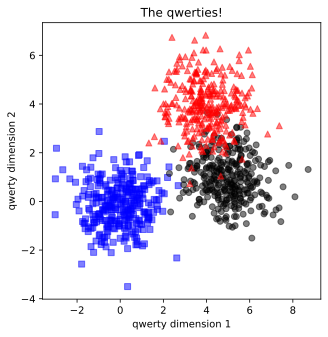

In [21]:
# create data

nPerClust = 300
blur = 1

A = [ 0, 0 ]
B = [ 5, 1 ]
C = [ 4, 4 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [22]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [23]:
# how many batches are there?

print(f'There are {len(train_loader)} batches, each with {batchsize} samples.')

There are 50 batches, each with 16 samples.


# The model

In [24]:
# create a class for the model
def createTheQwertyNet(optimizerAlgo, learningRate):

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)

      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)

  # create the model instance
  net = qwertyNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun = getattr( torch.optim,optimizerAlgo )
  optimizer = optifun(net.parameters(),lr=learningRate)

  return net,lossfun,optimizer


# A function that trains the model

In [25]:
def function2trainTheModel(optimizerType, learningRate):

  # number of epochs
  numepochs = 50

  # create a new model
  net,lossfun,optimizer = createTheQwertyNet(optimizerType, learningRate)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# A function that plots the results

In [56]:
# now run through all of them

# average performance
performanceTrain = np.zeros((3,20))
performanceTest = np.zeros((3,20))
learningRates = np.logspace(np.log10(0.001), np.log10(0.1), 20)

for idxOpto, opto in enumerate(['SGD','RMSprop','Adam']):
    for idxLr, lr in enumerate(learningRates):
        trainAcc,testAcc,losses,net = function2trainTheModel(opto, lr)

        # store the final results
        train = np.mean(trainAcc[-10:])
        test  = np.mean(testAcc[-10:])

        performanceTest[idxOpto][idxLr] = train
        performanceTrain[idxOpto][idxLr]= test

In [52]:
performanceTrain

array([[73.22222137, 90.44444275, 96.66667175, 98.88889313, 97.77777863,
        98.        , 98.88889313, 98.77778625, 98.88889313, 98.88889313,
        98.77778625, 98.88889313, 98.77778625, 98.88889313, 98.55555725,
        98.88889313, 98.88889313, 98.66667175, 98.77778625, 98.66666412],
       [98.88889313, 98.88889313, 98.88889313, 98.88889313, 98.88889313,
        98.88889313, 98.88889313, 98.88889313, 98.88889313, 98.88889313,
        98.88889313, 98.88889313, 98.77778625, 98.66666412, 98.55555725,
        98.66667175, 98.55555725, 98.44444275, 98.1111145 , 96.55555725],
       [98.88889313, 98.88889313, 98.77778625, 98.88889313, 98.88889313,
        98.88889313, 98.88889313, 98.77778625, 98.88889313, 98.88889313,
        98.88889313, 98.88889313, 98.77778625, 98.66666412, 98.77778625,
        98.77778625, 98.55555725, 98.66666412, 98.55555725, 97.88889313]])

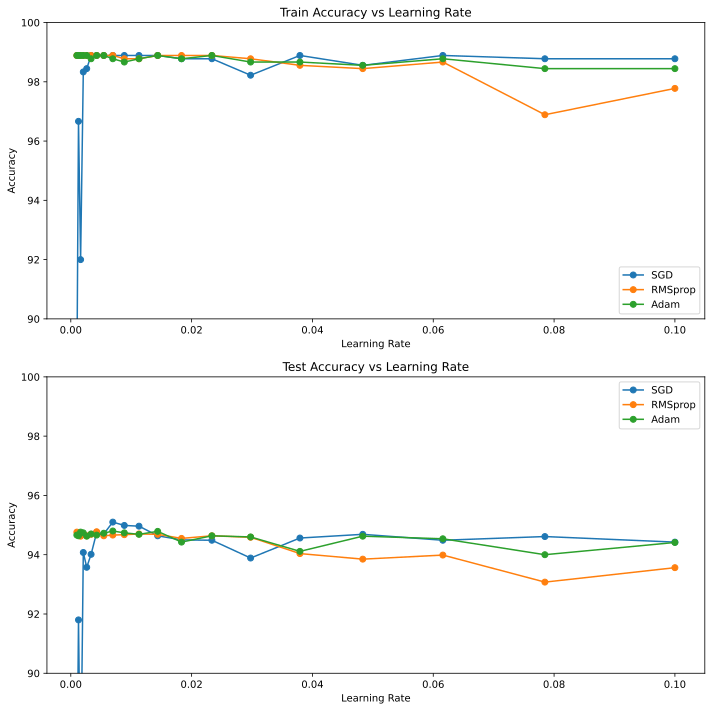

In [57]:
# Create subplots
optimizers = ['SGD', 'RMSprop', 'Adam']
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot train accuracies
for i in range(len(optimizers)):
    ax1.plot(learningRates, performanceTrain[i], marker='o', label=optimizers[i])

ax1.set_title('Train Accuracy vs Learning Rate')
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(90, 100)  # Set y-axis limits
ax1.legend()

# Plot test accuracies
for i in range(len(optimizers)):
    ax2.plot(learningRates, performanceTest[i], marker='o', label=optimizers[i])

ax2.set_title('Test Accuracy vs Learning Rate')
ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(90, 100)  # Set y-axis limits
ax2.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.show()